# Chlorophyll vs Control

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
#### print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [6]:
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [11]:
new.TLONG.values

array([[320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       ...,
       [320.25133086, 320.75380113, 321.25577325, ..., 318.74424456,
        319.24621668, 319.74869143],
       [320.23459477, 320.70358949, 321.17207442, ..., 318.82794339,
        319.29642832, 319.76542721],
       [320.21650899, 320.6493303 , 321.08163473, ..., 318.91838308,
        319.3506875 , 319.78351267]])

In [7]:
obsfiles = sorted(glob.glob('/glade/work/jluo/obs/SeaWiFS/climatology_regridded/'+'*L3m_MC_CHL_chl_ocx_gx1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

In [8]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [9]:
chla_new = np.nansum(np.stack([new.ppChl, new.mp1Chl, new.diazChl, new.diat1Chl, new.mp2Chl, new.diat2Chl, new.mp3Chl, new.diat3Chl, new.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan

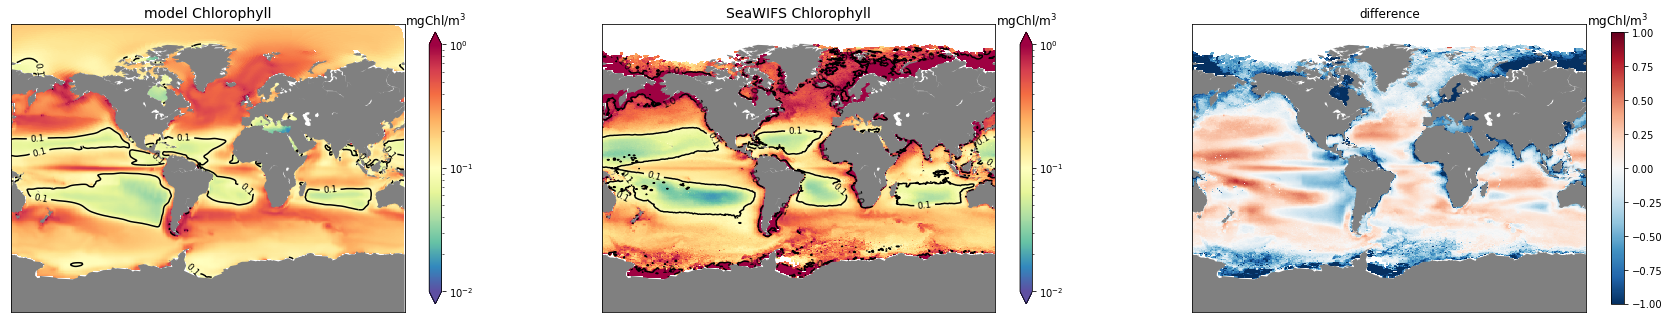

In [10]:
tlon, tlat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
x,y = m(tlon, tlat)
cf = ax.pcolor(x, y, chln, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=1))
cs = ax.contour(x, y, chln, levels =[0.01, 0.1, 1],colors='k')
lb = plt.clabel(cs, fontsize=9, inline=True, fmt='%r',inline_spacing=5);
ax.set_title('model Chlorophyll', fontsize = 14)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('$mg Chl$/$m^3$', fontsize = 12)

tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
x,y = m(tlono, tlato)
cf = ax.pcolor(x, y, chlno, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=1))
cs = ax.contour(x, y, chlno, levels =[0.01, 0.1, 1],colors='k')
lb = plt.clabel(cs, fontsize=9, inline=True, fmt='%r',inline_spacing=5);
ax.set_title('SeaWIFS Chlorophyll', fontsize = 14)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('$mg Chl$/$m^3$', fontsize = 12)

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolormesh(x,y,(np.log10(chln)-np.log10(chlno)),cmap='RdBu_r', vmin=-1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('$mg Chl$/$m^3$ ')
plt.title("difference")

plt.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_logChl_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [11]:
np.nanmin(np.log10(chln)-np.log10(chlno))

-2.2039876

### same figure, different style

In [12]:
# colors
lev = (0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.1)

<Figure size 1440x576 with 0 Axes>

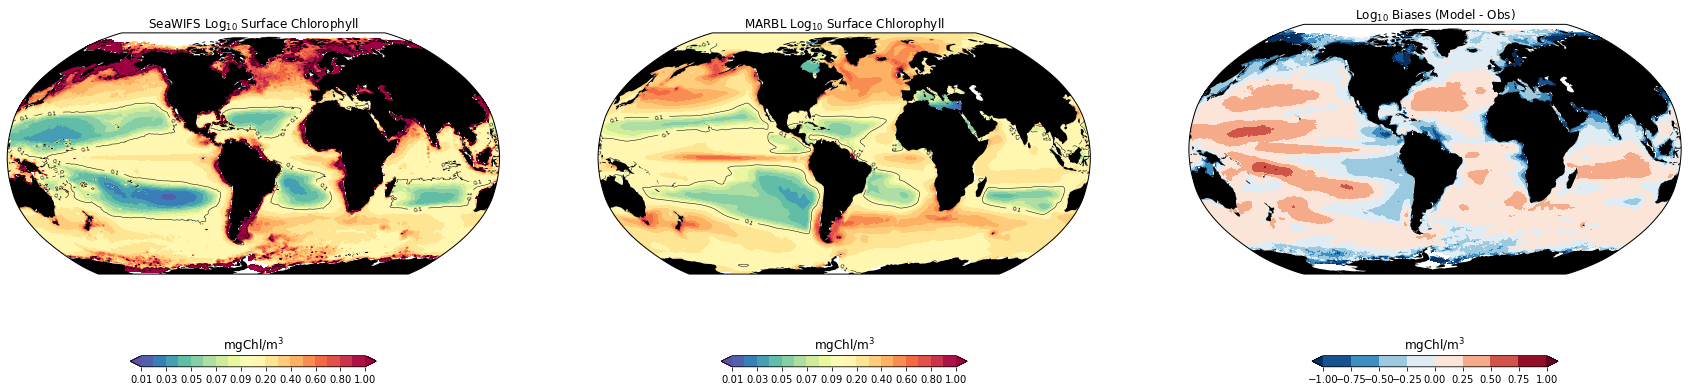

In [13]:
fig = plt.figure(figsize=(20, 8))

levv = (-1, -0.75,-0.5,-.25,0,0.25,0.5,0.75,1)
levels = (0.001,0.01,0.1,1)

fig = plt.figure(figsize=(30, 10))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0.01, vmax=1,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, chln, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('MARBL $Log_{10}$ Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
cf = ax.contourf(lon, lat, chlno,vmin=0.01, vmax=1,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, chlno, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('SeaWIFS $Log_{10}$ Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (np.log10(chln)-np.log10(chlno)), cmap='RdBu_r',vmin = -1, vmax =1, levels=levv, extend='both',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, (np.log10(chln)-np.log10(chlno)), colors='k', linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('$Log_{10}$ Biases (Model - Obs)');
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_logChl_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [14]:
# colors
lev = (-2, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-1)

<Figure size 1440x576 with 0 Axes>

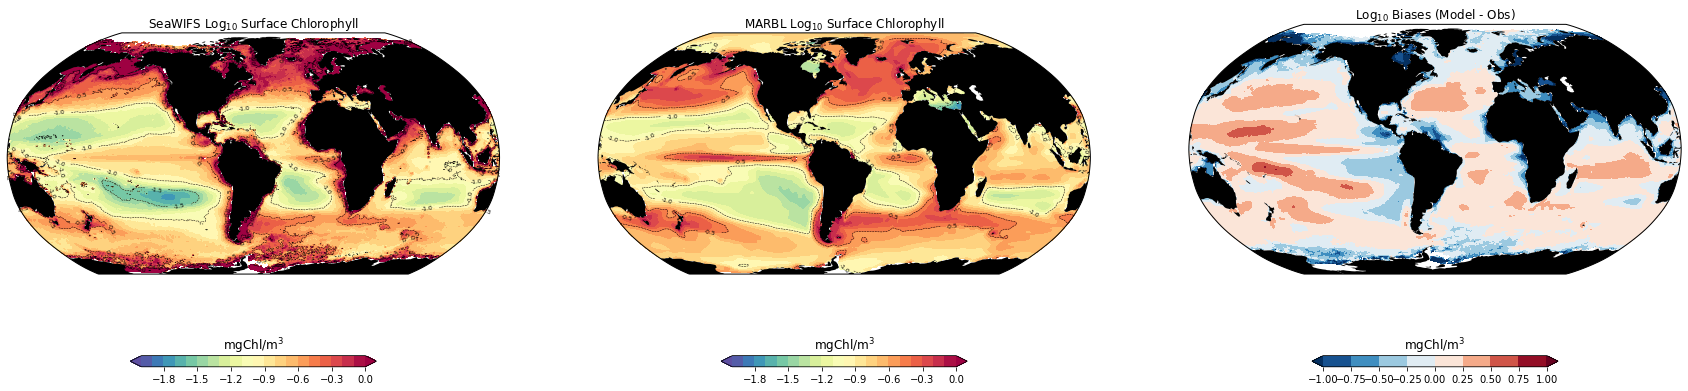

In [15]:
fig = plt.figure(figsize=(20, 8))

levv = (-1, -0.75,-0.5,-.25,0,0.25,0.5,0.75,1)
levels = (-1.5,-1,-0.5,0)

fig = plt.figure(figsize=(30, 10))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, np.log10(chln), vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chln), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('MARBL $Log_{10}$ Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
cf = ax.contourf(lon, lat, np.log10(chlno),vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chlno), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('SeaWIFS $Log_{10}$ Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (np.log10(chln)-np.log10(chlno)), cmap='RdBu_r',vmin = -1, vmax =1, levels=levv, extend='both',transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, (np.log10(chln)-np.log10(chlno)), colors='k', linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('$Log_{10}$ Biases (Model - Obs)');
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_logChl_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [18]:
RMSE = ((chln - chlno) ** 2).mean() ** .5
print(RMSE)

0.6751699646948256


In [ ]:
tlon, tlat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
x,y = m(tlon, tlat)
cf = ax.pcolor(x, y, chln, cmap='Spectral_r',vmin=0, vmax =2)
#cs = ax.contour(x, y, chln, levels =[0.01, 0.1, 1],colors='k')
#lb = plt.clabel(cs, fontsize=9, inline=True, fmt='%r',inline_spacing=5);
ax.set_title('MARBL Surface Chlorophyll', fontsize = 14)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('$mg Chl$/$m^3$', fontsize = 12)

tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
x,y = m(tlono, tlato)
cf = ax.pcolor(x, y, chlno, cmap='Spectral_r',vmin=0, vmax =2)
#cs = ax.contour(x, y, chlno, levels =[0.01, 0.1, 1],colors='k')
#lb = plt.clabel(cs, fontsize=9, inline=True, fmt='%r',inline_spacing=5);
ax.set_title('SeaWIFS Surface Chlorophyll', fontsize = 14)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('$mg Chl$/$m^3$', fontsize = 12)

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
x,y = m(tlono, tlato)
cf = m.pcolormesh(x,y,chln-chlno,cmap='RdBu_r', vmin =-1, vmax =1)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('$mg Chl$/$m^3$ ')
plt.title("difference")

plt.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_Chl_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [ ]:
# colors
lev = (0,0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)

<Figure size 1440x576 with 0 Axes>

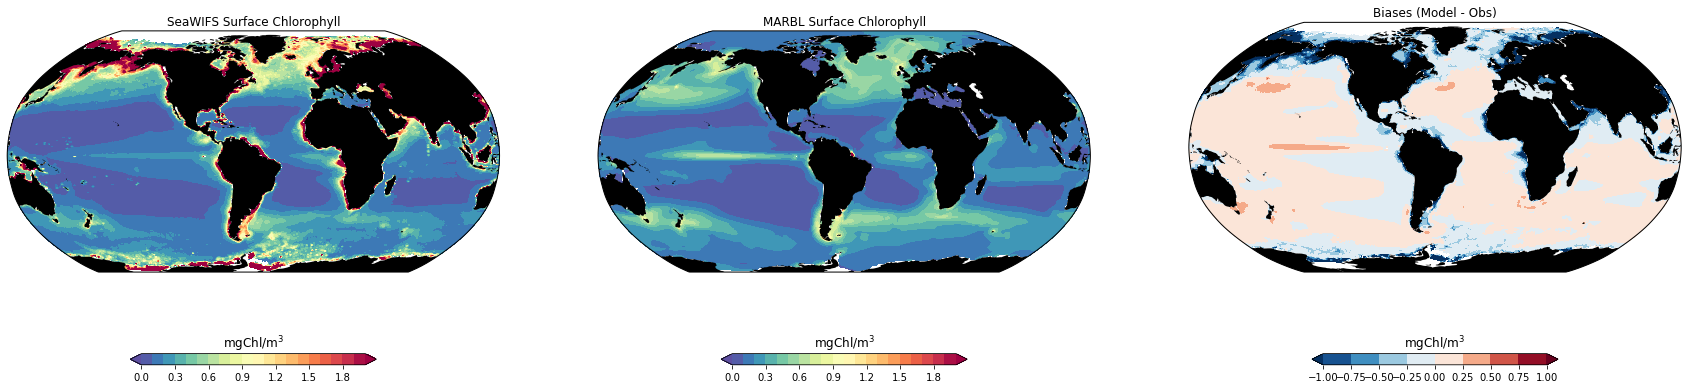

In [21]:
fig = plt.figure(figsize=(20, 8))

levv = (-1, -0.75,-0.5,-.25,0,0.25,0.5,0.75,1)
#levels = (0,1,2)

fig = plt.figure(figsize=(30, 10))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=2,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, chln, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('MARBL Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
cf = ax.contourf(lon, lat, chlno,vmin=0, vmax=2,levels=lev,norm=norm,extend='both', cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, chlno, colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('SeaWIFS Surface Chlorophyll');

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln - chlno, cmap='RdBu_r',vmin = -1, vmax =1, levels=levv,extend='both', transform=ccrs.PlateCarree());
#cs = ax.contour(lon, lat, (np.log10(chln)-np.log10(chlno)), colors='k', linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$mg Chl$/$m^3$')
ax.set_title('Biases (Model - Obs)');
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_Chl_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

Text(0.5, 1.0, '$\\%$ change')

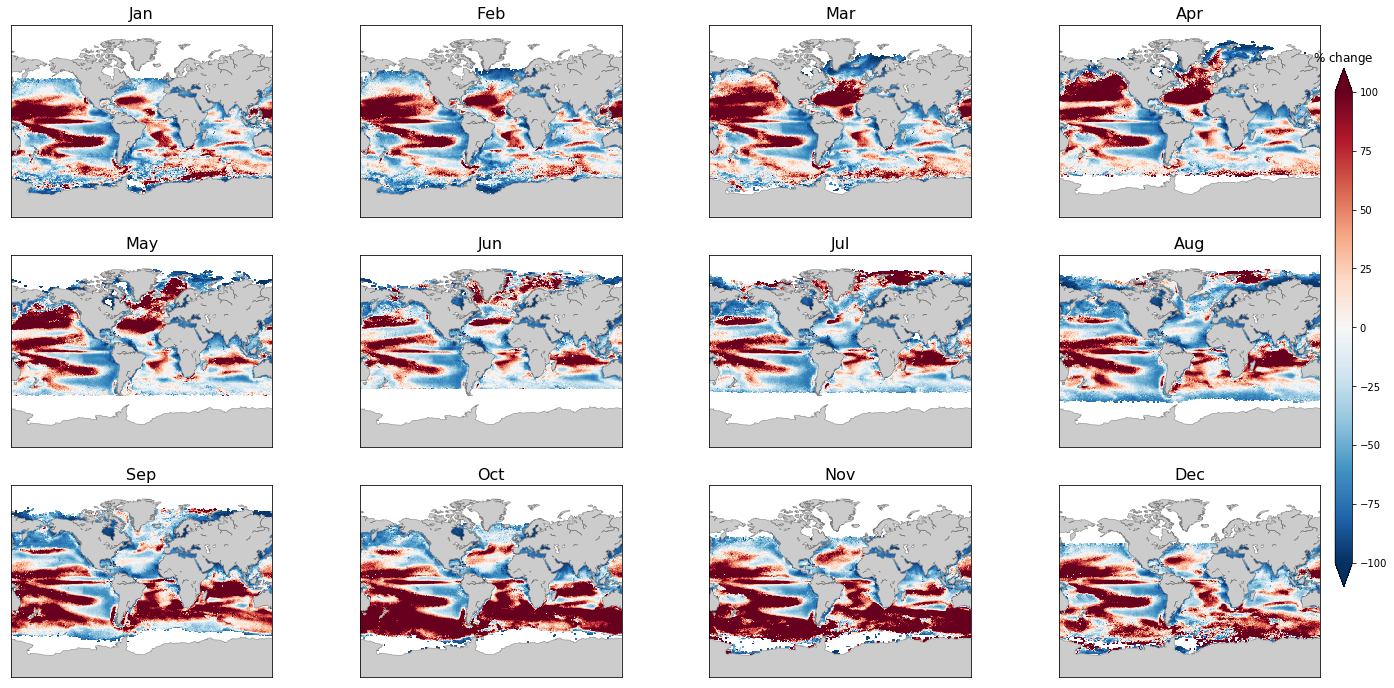

In [22]:
fig = plt.figure(figsize=(24, 12))

# month names 
phyto_names = ['Jan', 'Feb','Mar','Apr',
              'May','Jun','Jul','Aug',
              'Sep','Oct','Nov','Dec']

m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')

for i in range(1,13):
    ax = fig.add_subplot(3, 4, i)
    tlon, tlat, chln = adjust_pop_grid(new.TLONG, new.TLAT, chla_new[i-1,0,:,:])
    tlono, tlato, chlno = adjust_pop_grid(obs.TLONG[i-1,:,:], obs.TLAT[i-1,:,:], obs.chl_ocx[i-1,:,:])
    x,y = m(tlon, tlat)
    cf = m.pcolormesh(x,y,((chln-chlno)/chlno)*100,cmap='RdBu_r', vmin =-100, vmax =100)
    m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
    m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
    ax.set_title(''+str(phyto_names[i-1]), fontsize = 16)
    
cb_ax = fig.add_axes([0.9, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-100, vmax=100), 
                                      cmap='RdBu_r'),cax=cb_ax, extend = 'both')
cb.ax.set_title('$\% \u0394$ ')
plt.title("$\%$ change")
    
#fig.suptitle('(model - observations) / observations', x=0.5, y=.95,fontsize=24)
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_Chl_seasonal_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [23]:
chla_new = np.nansum(np.stack([new.ppChl, new.mp1Chl, new.diazChl, new.diat1Chl, new.mp2Chl, new.diat2Chl, new.mp3Chl, new.diat3Chl, new.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan # mg/m^3

chla_clim = np.sum(chla_new, axis = 1)* 10 * (new.TAREA / 1e4)
chla_clim = np.sum(chla_clim, axis = (1,2))

In [25]:
chla_clim = chla_new[:,0,:,:]
chla_clim = np.sum(chla_clim, axis = (1,2))

In [26]:
month = np.arange(1,13,1)

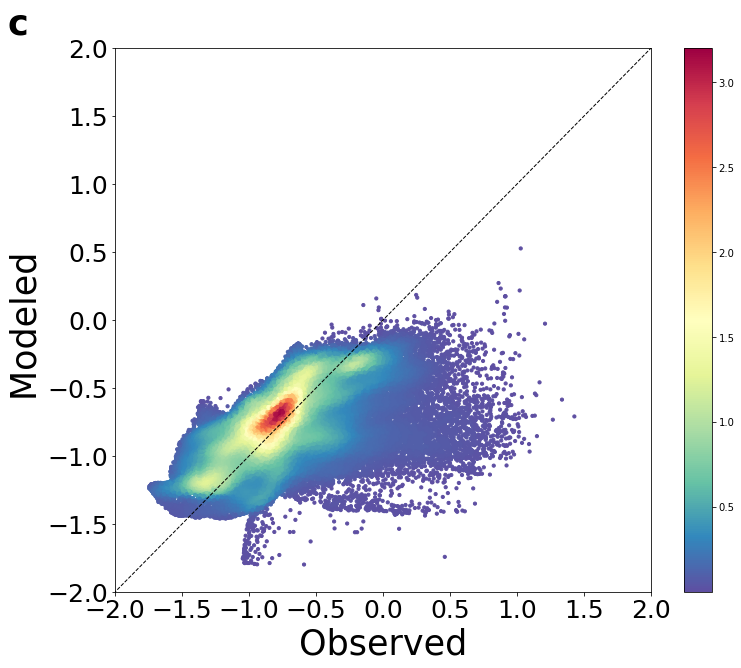

In [27]:
from scipy import stats
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(12, 10))
X=np.log10(np.nanmean(obs.chl_ocx[:,:,:], axis=0))[~np.isnan(np.log10(np.nanmean(obs.chl_ocx[:,:,:], axis=0)))& ~np.isnan(np.log10(np.nanmean(chla_new[:,0,:,:], axis=0)))]
Y=np.log10(np.nanmean(chla_new[:,0,:,:], axis=0))[~np.isnan(np.log10(np.nanmean(obs.chl_ocx[:,:,:], axis=0)))& ~np.isnan(np.log10(np.nanmean(chla_new[:,0,:,:], axis=0)))]

# Calculate the 
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([-3, 5], [-3, 5], color='k', linestyle='--', linewidth=1)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Observed', fontsize=35)
plt.ylabel('Modeled ',fontsize = 35)
fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
plt.colorbar()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/chl_scatter'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

Text(0, 0.9, 'c')

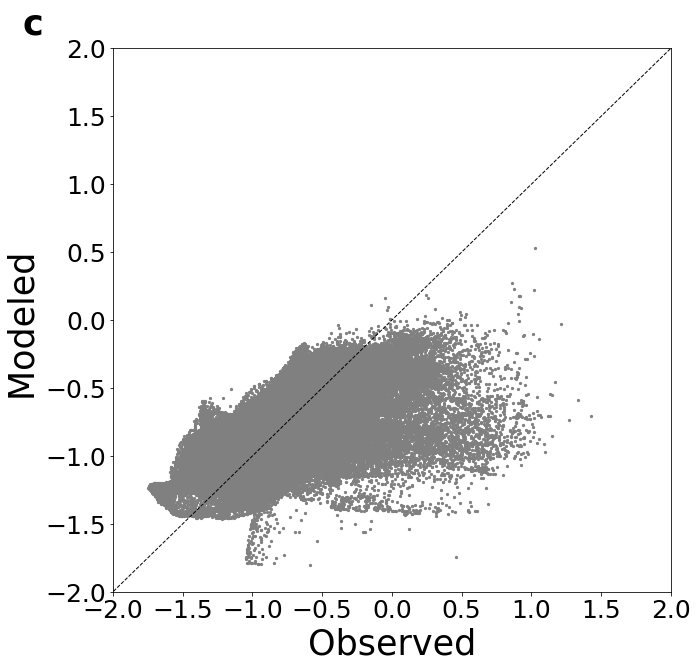

In [28]:
from scipy import stats
fig = plt.figure(figsize=(10, 10))
X=np.log10(np.nanmean(obs.chl_ocx[:,:,:], axis=0).flatten())
Y=np.log10(np.nanmean(chla_new[:,0,:,:], axis=0).flatten())

plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([-3, 5], [-3, 5], color='k', linestyle='--', linewidth=1)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Observed', fontsize=35)
plt.ylabel('Modeled ',fontsize = 35)
fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/chl_scatter'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

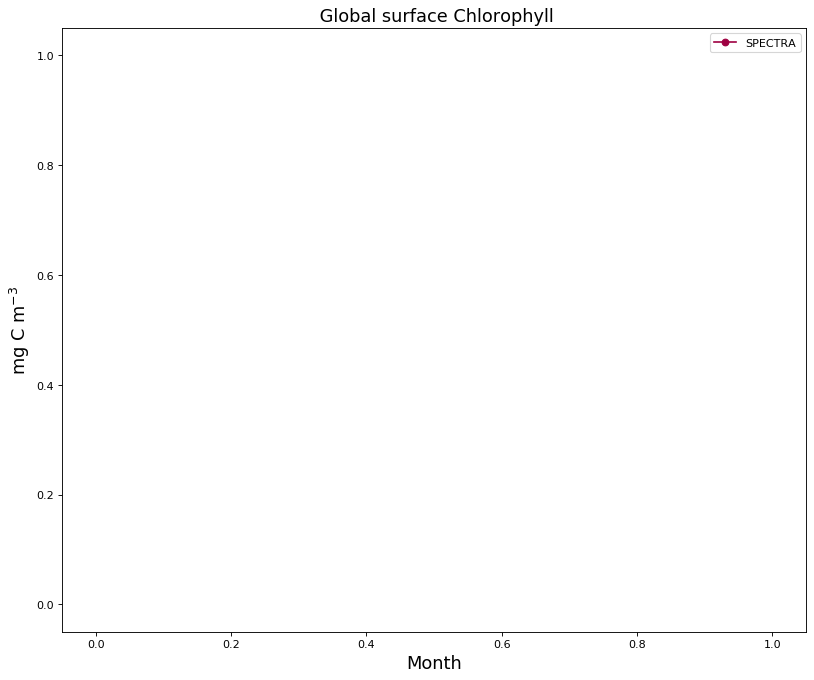

In [29]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
#dep = ds.z_t/100
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,chla_clim, '-o', color=cmap(0),label='SPECTRA')

pylab.legend(loc='upper right')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Global surface Chlorophyll', fontsize=16)
pylab.show()

## Now using gridded information, to be able to separate more easily by regions... 

# picoplankton 
pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

# diatoms 
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')
diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')
diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')


# Diazotrophs 
diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

# Mixed phytoplankton 
mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')
mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')
mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')
mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513b_chl/regrid_GNG513b_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

#TAREA regridded 
tarea_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG513_TAREA/regrid_GNG513b_TAREA.*.nc', recursive=True))
tarea_ds = xr.open_mfdataset(tarea_inds[0])

y = np.expand_dims(x, axis=0)

area = np.expand_dims([tarea_ds.TAREA.values,tarea_ds.TAREA.values,tarea_ds.TAREA.values,
        tarea_ds.TAREA.values,tarea_ds.TAREA.values,tarea_ds.TAREA.values,
        tarea_ds.TAREA.values,tarea_ds.TAREA.values,tarea_ds.TAREA.values,
        tarea_ds.TAREA.values,tarea_ds.TAREA.values,tarea_ds.TAREA.values],axis=0)

area.shape

chla_clim = np.nansum(np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl]), axis =0)
chla_clim[chla_clim<=0]=np.nan # mg/m^3

chla_south = chla_clim[:,0,0:60,:]* (area[0,0,0:60,:] / 1e4)
chla_south = np.nansum(chla_south, axis = (1,2))
chla_central = chla_clim[:,0,60:120,:]* (area[0,0,60:120,:] / 1e4)
chla_central = np.nansum(chla_central, axis = (1,2))
chla_north = chla_clim[:,0,120:180,:]* (area[0,0,120:180,:] / 1e4)
chla_north = np.nansum(chla_north, axis = (1,2))


chla_south = np.nansum(chla_clim[:,0,0:60,:], axis = (1,2))

chla_central = np.nansum(chla_clim[:,0,60:120,:], axis = (1,2))

chla_north = np.nansum(chla_clim[:,0,120:180,:], axis = (1,2))

import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
#dep = ds.z_t/100
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,chla_south, '-o', color=cmap(0),label='southern region')
pylab.plot(month,chla_central, '-o', color=cmap(1),label='central region')
pylab.plot(month,chla_north, '-o', color=cmap(2),label='northern region')

pylab.legend(loc='upper right')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Modeled surface chlorophyll', fontsize=16)
pylab.show()

## Create this same plot with the observations to see how their seasonal cycles compare 

obssfiles = sorted(glob.glob('/glade/u/home/gabyn/case_notes/obs/SeaWiFS/*', recursive=True),
                      key=numericalSort)
obs_01 = xr.open_mfdataset(obssfiles[0])
obs_02 = xr.open_mfdataset(obssfiles[1])
obs_03 = xr.open_mfdataset(obssfiles[2])
obs_04 = xr.open_mfdataset(obssfiles[3])
obs_05 = xr.open_mfdataset(obssfiles[4])
obs_06 = xr.open_mfdataset(obssfiles[5])
obs_07 = xr.open_mfdataset(obssfiles[6])
obs_08 = xr.open_mfdataset(obssfiles[7])
obs_09 = xr.open_mfdataset(obssfiles[8])
obs_10 = xr.open_mfdataset(obssfiles[9])
obs_11 = xr.open_mfdataset(obssfiles[10])
obs_12 = xr.open_mfdataset(obssfiles[11])

chl_obss = np.expand_dims([obs_01.chl_ocx.values,obs_02.chl_ocx.values,obs_03.chl_ocx.values,
        obs_04.chl_ocx.values,obs_05.chl_ocx.values,obs_06.chl_ocx.values,
        obs_07.chl_ocx.values,obs_08.chl_ocx.values,obs_09.chl_ocx.values,
        obs_10.chl_ocx.values,obs_11.chl_ocx.values,obs_12.chl_ocx.values],axis=0)

chla_south_obs = np.nansum(chl_obss[0,:,0:60,:], axis = (1,2))
chla_central_obs = np.nansum(chl_obss[0,:,60:120,:], axis = (1,2))
chla_north_obs = np.nansum(chl_obss[0,:,120:180,:], axis = (1,2))

import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
#dep = ds.z_t/100
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,chla_south_obs, '-o', color=cmap(0),label='southern region')
pylab.plot(month,chla_central_obs, '-o', color=cmap(1),label='central region')
pylab.plot(month,chla_north_obs, '-o', color=cmap(2),label='northern region')

pylab.legend(loc='upper right')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Observed surface chlorophyll', fontsize=16)
pylab.show()

import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
#dep = ds.z_t/100
fig = figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 3, 1)
pylab.plot(month,chla_south, '-o', color=cmap(0),label='southern region')
pylab.plot(month,chla_central, '-o', color=cmap(1),label='central region')
pylab.plot(month,chla_north, '-o', color=cmap(2),label='northern region')
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
pylab.legend(loc='upper left')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Modeled surface chlorophyll', fontsize=16)

ax = fig.add_subplot(1, 3, 2)
pylab.plot(month,chla_south_obs, '-o', color=cmap(0),label='southern region')
pylab.plot(month,chla_central_obs, '-o', color=cmap(1),label='central region')
pylab.plot(month,chla_north_obs, '-o', color=cmap(2),label='northern region')
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
pylab.legend(loc='upper left')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Observed surface chlorophyll', fontsize=16)


ax = fig.add_subplot(1, 3, 3)
pylab.plot(month,chla_south_obs, '-o', color=cmap(0),label=' OBS southern region')
pylab.plot(month,chla_central_obs, '-o', color=cmap(1),label='OBS central region')
pylab.plot(month,chla_north_obs, '-o', color=cmap(2),label='OBS northern region')
pylab.plot(month,chla_south, '--o', color=cmap(0),label='MOD southern region')
pylab.plot(month,chla_central, '--o', color=cmap(1),label='MOD central region')
pylab.plot(month,chla_north, '--o', color=cmap(2),label='MOD northern region')
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
pylab.legend(loc='upper left')
pylab.ylabel('mg C $m^{-3}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title('surface chlorophyll', fontsize=16)
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_Chl_cim'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

ax = sns.heatmap(np.log10(chl_obss[0,:,:,0]).transpose(), cmap='Spectral_r', vmin = -1.5, vmax = 0)
ax.invert_yaxis()

ax = sns.heatmap(np.log10(chla_clim[:,0,:,0]).transpose(), cmap='Spectral_r', vmin = -1.5, vmax = 0)
ax.invert_yaxis()

# (31°40′ N, 64°10′ W)
#Bermuda at 313500N, 643100W
# longitude in degrees East
res_lon = np.where(obs_01.lon == -64)

# Latitude degrees_north
res_lat = np.where(obs_01.lat == 31.5)

lonn = obs_01.lon[116]
latt = obs_01.lat[121]

fig = plt.figure(figsize=(20, 5))

lat = obs_01.lat
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(np.mean(chla_clim[:,0,:,:], axis=0)), coord=obs_01.lon, axis=1)
ax.plot(lonn, latt, 'o', markersize=10,color=cmap(0),transform=ccrs.PlateCarree())
cf = ax.pcolor(lon, lat, phyto, vmin = -1.5, vmax=0.5, cmap='Spectral_r',transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Modeled Chl', fontsize =16)
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both')
cbar.ax.set_title('$mg Chl$ $m^{-3}$', fontsize = 14)

lat = obs_01.lat
ax = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(np.mean(chl_obss[0,:,:,:], axis=0)), coord=obs_01.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto,  vmin = -1.5, vmax=0.5,cmap='Spectral_r',transform=ccrs.PlateCarree())
ax.plot(lonn, latt, 'o', markersize=10,color=cmap(0),transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Observed Chl', fontsize =16)
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both')
cbar.ax.set_title('$mg Chl$ $m^{-3}$', fontsize = 14)
fig.tight_layout()

levv = np.arange(-1, 1.1, 0.1)
levels = (-2,-1.5,-1,-0.5,0)
lev = np.arange(-2, 0.1, 0.1)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-1)
fig = plt.figure(figsize=(25, 12.5))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, np.log10(chln), vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chln), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-2,-1.5,-1,-0.5,0],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('Modeled $Log_{10}$ Surface Chlorophyll', fontsize=20);
fig.text(0.385, 0.97, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
cf = ax.contourf(lon, lat, np.log10(chlno),vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chlno), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-2,-1.5,-1,-0.5,0],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('Observed $Log_{10}$ Surface Chlorophyll', fontsize=20);
fig.text(0.06, 0.97, 'a',fontsize=20, fontweight='bold')

levels = (-1,-0.5,0,0.5,1)
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (np.log10(chln)-np.log10(chlno)), cmap='RdBu_r',vmin = -1, vmax =1, levels=levv, extend='both',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, (np.log10(chln)-np.log10(chlno)), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1,-0.5,0,0.5,1],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('($Log_{10}$ Model - $Log_{10}$ Obs.)', fontsize=20);
fig.text(0.71, 0.97, 'c',fontsize=20, fontweight='bold')


Models = ['Obs.', 'SPECTRA']
ax = fig.add_subplot(2, 3, 5)
sns.heatmap(np.log10(chl_obss[0,:,:,0]).transpose(), cbar=0,vmax=0,vmin=-2,cmap='Spectral_r')
ax.invert_yaxis()
plt.yticks(np.arange(0,181,20), ['-80', '-60', '-40', '-20',   '0',  '20',  '40',  '60',  '80'])
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.06, 0.51, 'd',fontsize=20, fontweight='bold')
for _, spine in ax.spines.items():
    spine.set_visible(True)

ax = fig.add_subplot(2, 3, 4)
sns.heatmap(np.log10(chla_clim[:,0,:,0]).transpose(),cbar=0, vmax=0,vmin=-2,cmap='Spectral_r')
ax.invert_yaxis()
plt.yticks(np.arange(0,181,20), ['-80', '-60', '-40', '-20',   '0',  '20',  '40',  '60',  '80'])
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.385, 0.51, 'e',fontsize=20, fontweight='bold')
for _, spine in ax.spines.items():
    spine.set_visible(True)
    
# bias plot
ax = fig.add_subplot(2, 3, 6)
diffs = np.log10(chla_clim[:,0,:,0]) - np.log10(chl_obss[0,:,:,0])
sns.heatmap(diffs.transpose(), cbar=0,vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
ax.invert_yaxis()
plt.yticks(np.arange(0,180,20), ['80', '60', '40', '20',   '0',  '-20',  '-40',  '-60',  '-80'])
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)', fontsize=22)
fig.text(0.71, 0.51, 'f',fontsize=20, fontweight='bold')
for _, spine in ax.spines.items():
    spine.set_visible(True)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_logChl_lat'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
ax = fig.add_subplot(2, 3, 5)
sns.heatmap(np.log10(chla_new[:,0,:,0]).transpose(), vmax=0,vmin=-2,cmap='Spectral_r')
#plt.yticks(np.arange(-80,81,20), ['-80', '-60', '-40', '-20',   '0',  '20',  '40',  '60',  '80'])
#plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.06, 0.51, 'd',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
sns.heatmap(np.log10(obs.chl_ocx[:,:,0]).transpose(), vmax=0,vmin=-2,cmap='Spectral_r')
plt.yticks(np.arange(-80,81,20), ['-80', '-60', '-40', '-20',   '0',  '20',  '40',  '60',  '80'])
#plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.385, 0.51, 'e',fontsize=20, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
diffs = np.log10(chla_new[:,0,:,0]) - np.log10(obs.chl_ocx[:,:,0])
sns.heatmap(diffs.transpose(), vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
#plt.yticks(np.arange(-80,81,20), ['-80', '-60', '-40', '-20',   '0',  '20',  '40',  '60',  '80'])
#plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)', fontsize=22)
fig.text(0.71, 0.51, 'f',fontsize=20, fontweight='bold')
fig.tight_layout()

np.log10(chl_obss[0,:,:,0]).transpose().shape

## Now compare with Biomes

In [30]:
#biome_mask = xr.open_dataset('/glade/u/home/jluo/p/tools/biomes/g.e20.G1850ECOIAF.t62_g17.marbl0_22_0.test117/biomes_mask_0033_0062.nc')
#biome_mask = biome_mask.isel(time=0)
#biome_mask.reset_coords('time', drop=True)
biome_mask = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124.nc')

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

In [31]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [32]:
nbiome = len(biome_mask.region.values)
nt = len(obs.time.values)

### SPECTRA Chl

In [33]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'Chl' for v in phyto_names]
chla_new = xr.concat([new[v] for v in phyto_vars], dim='var').sum(dim='var') # units are mmol m-3 * cm s-1

### Load Control files 

In [34]:
#ff = sorted(glob('/glade/scratch/jluo/archive/g.e20b07.G1850ECOIAF.t62_g17.marbl0_22_0.oob/ocn/hist/g.e20b07.G1850ECOIAF.t62_g17.marbl0_22_0.oob.pop.h.00' + '%02d'%(yy+1) + '*.nc'))
#ff

dc = xr.open_mfdataset(ff, concat_dim='time', decode_times=False, decode_coords=False)

dsi = xr.open_mfdataset(ff[0],decode_times=False,decode_coords=False)
grid_vars = [v for v in dsi.variables if 'time' not in dsi[v].dims]
ecosystem_vars = ['photoC_sp', 'photoC_diat', 'photoC_diaz']
grid = dsi.drop([v for v in dsi.variables if v not in grid_vars])

dc = dc.drop([v for v in dc.variables if v not in ecosystem_vars])
dc = xr.merge((dc, grid))

dc['photoC_TOT'] = xr.concat([dc[v] for v in ecosystem_vars],dim='var').sum(dim='var')
dc = dc.drop(ecosystem_vars)

### Calculate observations and satellite data at each region of the biome

In [35]:
index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=r).values == 1)

    for t in range(nt):
        tmp_obs = np.log10(chla_new.isel(z_t_150m=0, time=t).values[region])
        biome_means[t,i,1] = np.nanmean(tmp_obs)
        
        tmp_sat = np.log10(obs.chl_ocx.isel(time=t).values[region])
        biome_means[t,i,0] = np.nanmean(tmp_sat)
        #tmp_bec = np.log10(dc.totChl.isel(z_t_150m=0, time=t).values[region])
        #biome_means[t,i,2] = np.nanmean(tmp_bec)

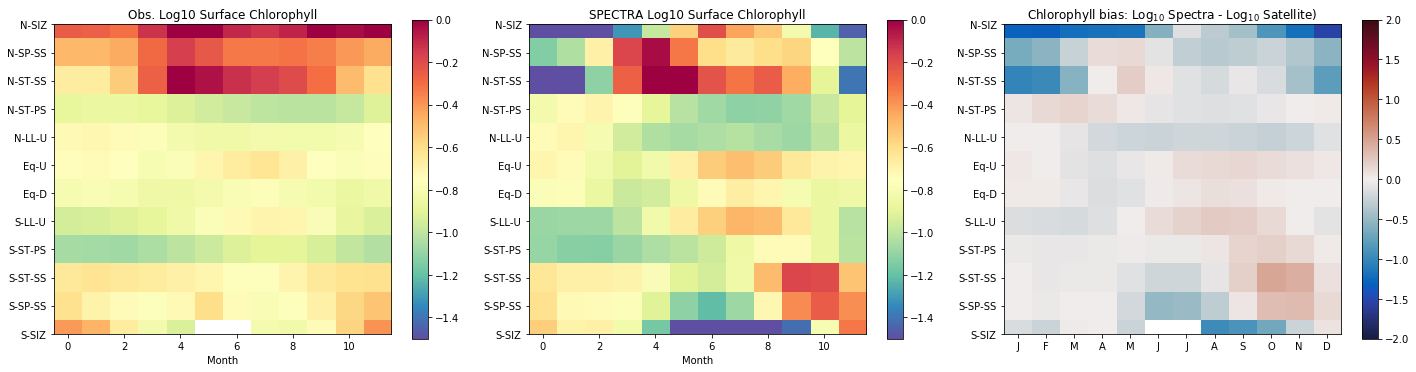

In [36]:
Models = ['Obs.', 'SPECTRA']

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(20,5))

for i in range(2):    
    f = plt.subplot(gs[0,i])
    plt.imshow(biome_means[:,:,i].T, vmax=0,vmin=-1.5,cmap='Spectral_r')
    plt.yticks(range(nbiome), region_NtoS_names)
    plt.xlabel('Month')
    plt.colorbar()
    plt.title(Models[i] + ' Log10 Surface Chlorophyll')

# bias plot
f = plt.subplot(gs[0,2])
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=2.0, vmin=-2.0, cmap=cmocean.cm.balance)
plt.yticks(np.arange(0,12,1), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
#plt.xlabel('Month')
plt.title('Chlorophyll bias: $Log_{10}$ Spectra - $Log_{10}$ Satellite)')
plt.colorbar()


plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_seasonal_comparison_biomes_bias'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Create a full figure with these

In [37]:
# colors
lev = np.arange(-2, 0.1, 0.1)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-1)

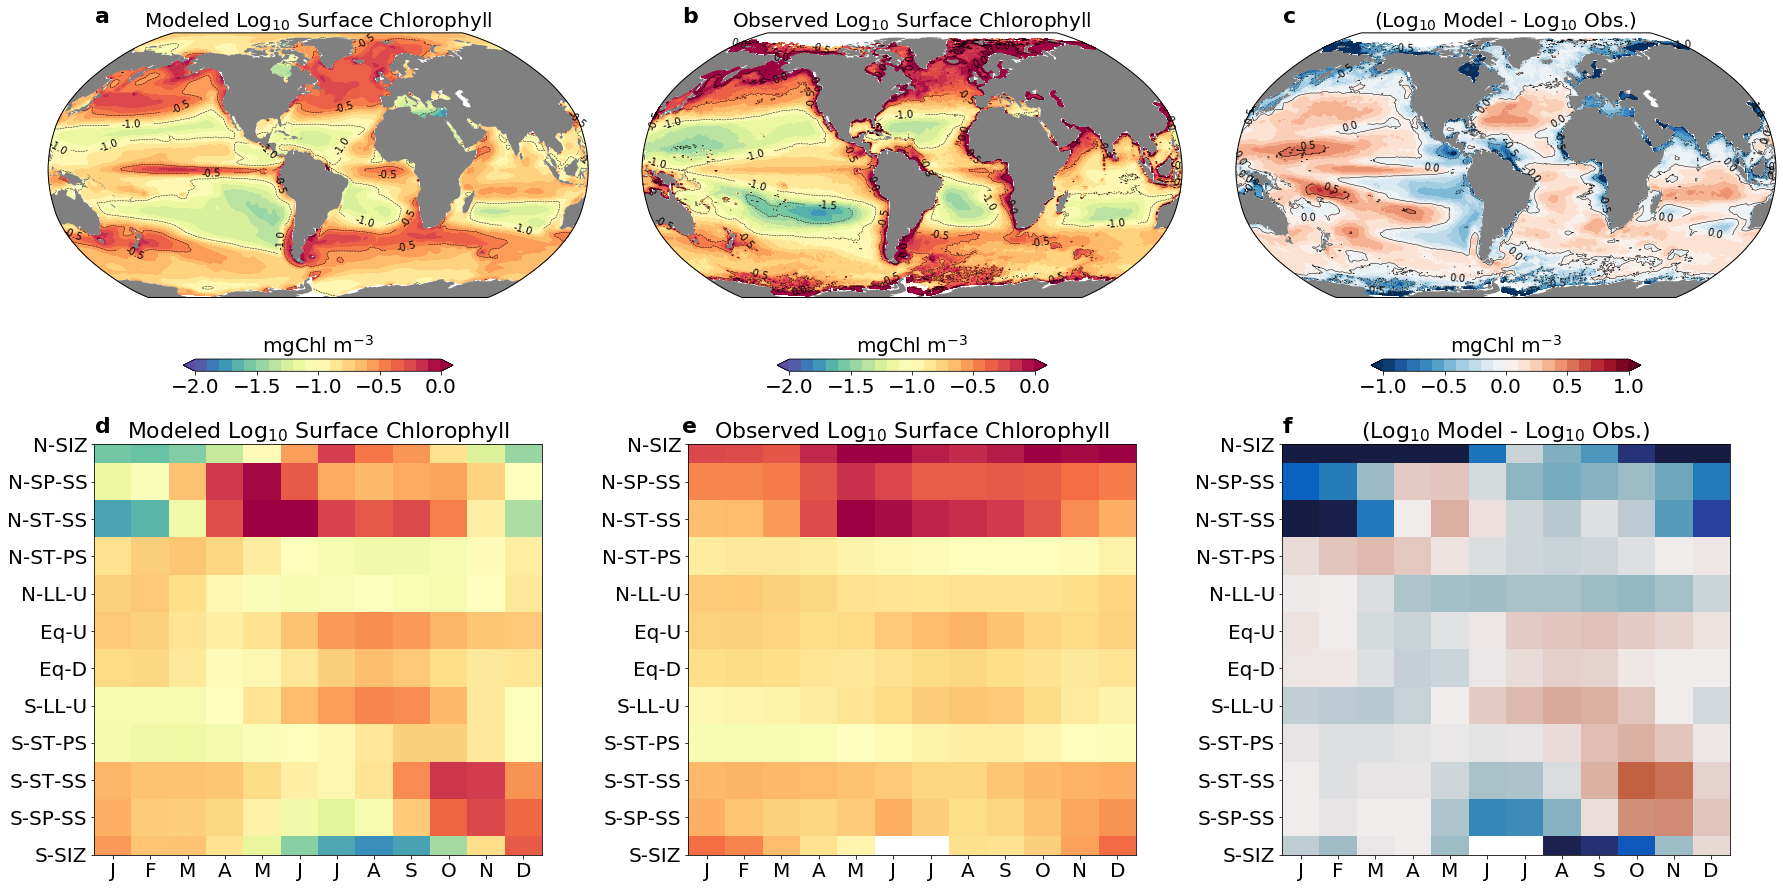

In [39]:
levv = np.arange(-1, 1.1, 0.1)
levels = (-2,-1.5,-1,-0.5,0)

fig = plt.figure(figsize=(25, 12.5))
lon, lat, chln = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[:,0,:,:], axis=0))
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, np.log10(chln), vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chln), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-2,-1.5,-1,-0.5,0],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('Modeled $Log_{10}$ Surface Chlorophyll', fontsize=20);
fig.text(0.3862, 0.965, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlono, tlato, chlno = adjust_pop_grid(np.nanmean(obs.TLONG[:,:,:], axis=0), np.nanmean(obs.TLAT[:,:,:], axis=0), np.nanmean(obs.chl_ocx[:,:,:], axis=0))
cf = ax.contourf(lon, lat, np.log10(chlno),vmin=-2, vmax=0,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, np.log10(chlno), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-2,-1.5,-1,-0.5,0],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('Observed $Log_{10}$ Surface Chlorophyll', fontsize=20);
fig.text(0.06, 0.965, 'a',fontsize=22, fontweight='bold')

levels = (-1,-0.5,0,0.5,1)
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (np.log10(chln)-np.log10(chlno)), cmap='RdBu_r',vmin = -1, vmax =1, levels=levv, extend='both',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, (np.log10(chln)-np.log10(chlno)), colors='k', levels=levels, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1,-0.5,0,0.5,1],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$mg Chl$ $m^{-3}$', fontsize=20)
ax.set_title('($Log_{10}$ Model - $Log_{10}$ Obs.)', fontsize=20);
fig.text(0.72, 0.965, 'c',fontsize=22, fontweight='bold')


Models = ['Obs.', 'SPECTRA']
ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmax=0,vmin=-2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.06, 0.51, 'd',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmax=0,vmin=-2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Surface Chlorophyll', fontsize=22)
fig.text(0.3862, 0.51, 'e',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)', fontsize=22)
fig.text(0.72, 0.51, 'f',fontsize=22, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/surf_logChl'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## If you do not want the biomes, but want the Latitude instead... 
### this is tricky, becuase I would have to regrid the grid to have a continuous, and correct map, I think 

ax = sns.heatmap(chla_new[:,0,:,0].transpose(), cmap='Spectral_r', vmin = 0, vmax = 2)
ax.invert_yaxis()

### Calculate mixed layer depths?

FIG. 1. Monthly mean (top) maximum and (bottom) minimum mixed layer depths from the CESM during the 1990s are compared with observed mixed layer depths from the WOA2009 (Locarnini et al. 2010; Antonov et al. 2010). Mixed layer depths were calculated from annual mean density fields as the depth where the density difference from surface waters exceeded 0.125 g L21.